In [ ]:
#| default_exp diffusion_laziness
# Diffusion Curvature utils
from diffusion_curvature.utils import *
from diffusion_curvature.datasets import *
# Python necessities
import numpy as np
import jax
import jax.numpy as jnp
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
from fastcore.all import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Laziness Estimators
> What's the shape of this diffusion?

# Wasserstein Spread of Diffusion

In [ ]:
#|export
import jax.numpy as jnp
from jax import jit

@jit
def wasserstein_spread_of_diffusion(
                D:jax.Array, # manifold geodesic distances
                Pt:jax.Array, # powered diffusion matrix/t-step ehat diffusions
                ):
        """
        Returns how "spread out" each diffusion is, with wasserstein distance
        Presumes that the manifold distances have been separately calculated
        """
        return jnp.sum(D * Pt, axis=-1)

### Benchmarking

In [ ]:
D = np.random.rand(1000,1000)
Pt = np.random.rand(1000,1000)
Pt = Pt / np.sum(Pt, axis=1)[:,None]

In [ ]:
%%timeit
wasserstein_spread_of_diffusion(D,Pt)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


1.08 ms ± 57.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
key = jax.random.PRNGKey(0)
Djax = jax.random.normal(key, (1000, 1000))
key = jax.random.PRNGKey(10)
Ptjax = jax.random.normal(key, (1000, 1000))

In [ ]:
%%timeit
wasserstein_spread_of_diffusion(Djax,Ptjax)

706 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Wow, it's nearly two orders of magnitude faster when using jax arrays.

# Entropy of Diffusion

In [ ]:
#|export
import jax.scipy
import jax.numpy as jnp

def entropy_of_diffusion(
    Pt:jax.Array, # powered diffusion matrix
    epsilon=1e-5, # threshold for small values, for speed
): 
        """
        Returns the pointwise entropy of diffusion from the powered diffusion matrix in the input
        Assumes that Pt sums to 1
        """
        # Use only the elements of Pt that are greater than epsilon
        Pt = Pt * (Pt>epsilon)
        # Normalize Pt so that it sums to 1
        Pt = Pt / (jnp.sum(Pt, axis=-1) + 1e-12)
        # Pt = (Pt + 1e-10) /(1 + 1e-10*Pt.shape[0]) # ensure, for differentiability, that there are no zeros in Pt, but that it still sums to 1.
        entropy_elementwise = jax.scipy.special.entr(Pt)
        entropy_of_rows = jnp.sum(entropy_elementwise, axis=-1)
        # normalize so max value is 1
        # entropy_of_rows = entropy_of_rows / (-jnp.log(1/jnp.sum(Pt>epsilon, axis=-1)))
        return entropy_of_rows

In [ ]:
from scipy.stats import entropy

In [ ]:
assert jnp.allclose(entropy_of_diffusion(Pt),entropy(Pt,axis=1), atol = 1e-3)

# Diffusion Laziness Model

The above functions estimate the laziness of a powered diffusion matrix, at a single time. Here, we extend the computation over multiple times, as well as making it more convenient to call.

## Get Multiple Powers of Diffusion at Once

The first step is taking a diffusion matrix, and a list of times, and producing powerings of the matrix for each time.
We do this by beginning with the lowest number, then for each subsequent number, taking its additive factors (i.e. partitions), seeing if any of them are already in the list, and using them if so.

In [ ]:
#|export
from typing import List
import math

def get_matrix_power_recursive(
    desired_power:int, 
    Pt_dict:dict, # should be, by default, {1 : P}
):
    if desired_power in Pt_dict.keys():
        return Pt_dict[desired_power], Pt_dict
    # Given no existing keys, we factor things into the closest powers of two. But if there is a large existing key (larger than the poewr of two), we'll use that.
    best_power = desired_power // 2
    max_power = max(Pt_dict.keys())
    if max_power >= best_power and max_power < desired_power: u = max_power
    else:
        u = best_power
        _, Pt_dict = get_matrix_power_recursive(best_power, Pt_dict)
    P_minusmax, Pt_dict = get_matrix_power_recursive(abs(desired_power - u), Pt_dict)
    Pt = Pt_dict[u] @ P_minusmax
    Pt_dict[desired_power] = Pt
    return Pt, Pt_dict


def powers_of_diffusion(
    P:jax.Array, # diffusion matrix
    ts:List[Int], # list of times 
)->List[jax.Array]: 
    """
    Returns list[P^t for t in ts], but done efficiently.
    """
    Pt_dict = { 1: P }
    Pts = []
    for t in ts:
        Pt, Pt_dict = get_matrix_power_recursive(t, Pt_dict)
        Pts.append(Pt)
    return Pts

Sanity check

In [ ]:
A = random_jnparray(10,10)
A_19, A_power_dict = get_matrix_power_recursive(
    19, {1:A}
)

In [ ]:
jnp.allclose(jnp.linalg.matrix_power(A, 19), A_19)

Array(True, dtype=bool)

In [ ]:
A_power_dict.keys()

dict_keys([1, 2, 4, 5, 9, 10, 19])

Speed test: jnp's implementation of matmul is, as expected faster. But only by a factor of 5. That's pretty good. Quite likely python is the cause of slowness, not the algorithm we've used.

In [ ]:
%%timeit
t = np.random.randint(40,60)
At, Adict = get_matrix_power_recursive(t, { 1 : A })

41.3 µs ± 90.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
t = np.random.randint(40,60)
At = jnp.linalg.matrix_power(A, t)

9.04 µs ± 19.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now let's test the real use case: getting powered matrices from a list of powers.

In [ ]:
ts = [1,2,3,4,5,6,7,8,10,13,15,17,21,25, 33, 55]
Pts = powers_of_diffusion(A, ts)
for i,t in enumerate(ts):
    assert jnp.allclose(Pts[i], jnp.linalg.matrix_power(A, t))

Timing it, we've now become faster than the bare metal -- though surprisingly not by that much.

In [ ]:
%%timeit
ts = np.arange(1,100)
Pts = powers_of_diffusion(A, ts)

597 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
ts = np.arange(1,100)
Pts = [jnp.linalg.matrix_power(A, t) for t in ts]

694 µs ± 476 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We also see that computing a hundred sequential powers instead of one only scales by a factor of ten, versus, for the basic jax, a factor of 100. That's the important constant.

## Divergences and Distances

In [ ]:
# test data
from diffusion_curvature.datasets import sphere
from diffusion_curvature.kernels import *
import scipy

In [ ]:
#|export
@jax.jit
def kl_div(A, B, eps = 1e-12):
    # Calculate Kullback-Leibler divergence
    # get rid of zero values
    A = jnp.where(A == 0, eps, A)
    B = jnp.where(B == 0, eps, B)
    v = A*(jnp.log(A) - jnp.log(B)) 
    return jnp.sum(v)

In [ ]:
test_eq(
    kl_div(Pts[0][1], Pts[10][1]).item(), 
    scipy.special.kl_div(Pts[0][1], Pts[10][1]).sum()
)

In [ ]:
#|export
@jax.jit
def js_dist(
    P:jax.Array, 
    Q:jax.Array,
):
    """Compute the Jensen-Shannon distance between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    M = 0.5 * (P + Q)

    # Get the JS DIVERGENCE
    result = 0.5 * (kl_div(P, M) + kl_div(Q, M))
    # Take sqrt to get the JS DISTANCE
    return jnp.sqrt(jnp.abs(result))

In [ ]:
assert jnp.allclose(
    js_dist(Pts[0][1], Pts[10][1]).item(), 
    scipy.spatial.distance.jensenshannon(Pts[0][1], Pts[10][1]).sum()
)

One can vectorize these functions with jax.vmap

In [ ]:
js_dist_vectorized = jax.vmap(js_dist, (0, 0), 0)

In [ ]:
vect_output = js_dist_vectorized( Pts[3], Pts[20])
for i, v in enumerate(vect_output):
    test_eq(v, js_dist(Pts[3][i], Pts[20][i]))

## Integrating laziness over time

In [ ]:
ts = np.arange(1,50)
Pts = powers_of_diffusion(P, ts)

We must convert times to distances along the diffusion trajectory.

In [ ]:
#|export
from scipy.spatial.distance import jensenshannon
def diffusion_distances_along_trajectory(diffusions):
    # given a sequence of diffusions, returns the distances between each 
    js_dist_vectorized = jax.vmap(js_dist, (0, 0), 0)
    distances = [jnp.zeros(diffusions[0].shape[0])]
    for idx in range(len(diffusions)-1):
        step_distance = js_dist_vectorized(diffusions[idx+1], diffusions[idx])
        distances.append(
            distances[-1] + step_distance
        )
    return jnp.stack(distances)

In [ ]:
ds = diffusion_distances_along_trajectory(Pts)

In [ ]:
ds.shape

(49, 1000)

We'll use a trapezoidal style integral.

In [ ]:
#|export
import jax
import jax.numpy as jnp

def trapezoidal_rule(x, y):
    # Ensure x and y are JAX arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    
    # Calculate the differences between consecutive x values along the second axis (axis=1)
    dx = x[:, 1:] - x[:, :-1]
    
    # Calculate the trapezoidal areas along the second axis
    trapezoidal_areas = dx * (y[:, :-1] + y[:, 1:]) / 2
    
    # Sum up the areas along the second axis to get the integral for each row
    integral = jnp.sum(trapezoidal_areas, axis=1)
    
    return integral

In [ ]:
# Example usage
N = 5
M = 1000
x = jnp.linspace(0, 1, M).reshape(1, M).repeat(N, axis=0)  # N x M array of x values
y = x**2  # y = f(x) = x^2 for each row

result = trapezoidal_rule_batch(x, y)
print(result)  # Output should be an array of size N with values close to 1/3 ≈ 0.3333

[0.3333335 0.3333335 0.3333335 0.3333335 0.3333335]


## Diffusion Laziness Wrapper

In [ ]:
#|export
from typing import Literal
from diffusion_curvature.kernels import diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_from_dirac

class DiffusionLaziness():
    DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
    LAZINESS_METHODS = Literal['Entropic', 'Wasserstein']
    def __init__(
        self,
        diffusion_type:DIFFUSION_TYPES = "diffusion matrix",
        laziness_method:LAZINESS_METHODS = "Entropic",
    ):
        store_attr()


    def fit_transform(
        self,
        G, # graph
        ts, # time or list of times.
        D = None,
        t_dist:int = 25, # diffusion time for distance calculation
    ):
        # get jax affinity matrix, and compute diffusion matrix from graph
        W = G.W
        if scipy.sparse.issparse(W):
            W = W.todense()
        if D is None: ts += [t_dist]
        W = jnp.array(W)
        # get powers of diffusion
        match self.diffusion_type:
            case 'diffusion matrix':
                P = diffusion_matrix_from_affinities(W)
                Pts = powers_of_diffusion(P, ts)
            case 'heat kernel':
                raise NotImplementedError # TODO: Implement and test
                Pts = heat_diffusion_from_dirac(G, ts)
        match self.laziness_method:
            case "Wasserstein":
                if D is None: D = phate_distances(Pts[-1])
                laziness_with_distance = partial(wasserstein_spread_of_diffusion, D = D)
                laziness_fn = jax.vmap(wasserstein_spread_of_diffusion)
            case "Entropic":
                laziness_fn = jax.vmap(entropy_of_diffusion, (0), 0)
        if D is None: diffusions = Pts[:-1] # the last Pt is for heat 
        print(len(diffusions))
        self.ls = laziness_fn(jnp.stack(diffusions)).T 
        self.ds = diffusion_distances_along_trajectory(diffusions).T
        laziness_under_curve = trapezoidal_rule(self.ds, self.ls)
        return laziness_under_curve

We'll test this with our old friend, the torus.

In [ ]:
X, ks = torus(2000)
G = get_adaptive_graph(X)

2024-07-09 14:08:03,347:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
Laziness = DiffusionLaziness()
ks = Laziness.fit_transform(G, ts = list(range(1,40)))

39


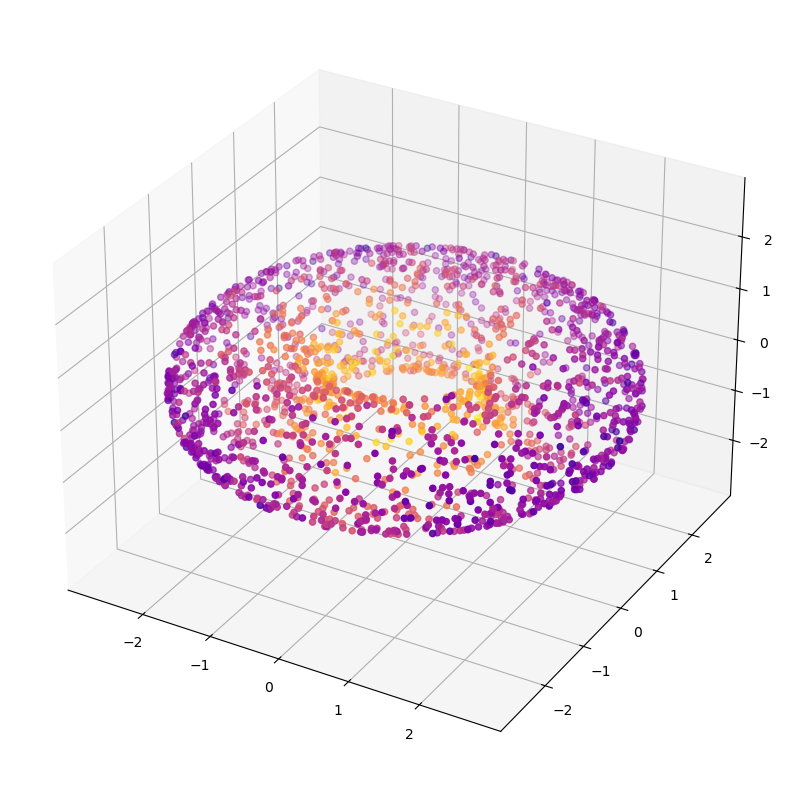

In [ ]:
plot_3d(X, ks)